In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [3]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [4]:
from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

In [5]:
airbnb= pd.read_csv(r'../airbnb_raw.csv')

In [6]:
#Checking the NaNs in all collumns 
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41714 entries, 0 to 41713
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   City                         41714 non-null  object 
 1   Price                        41714 non-null  float64
 2   Day                          41714 non-null  object 
 3   Room Type                    41714 non-null  object 
 4   Shared Room                  41714 non-null  bool   
 5   Private Room                 41714 non-null  bool   
 6   Person Capacity              41714 non-null  float64
 7   Superhost                    41714 non-null  bool   
 8   Multiple Rooms               41714 non-null  int64  
 9   Business                     41714 non-null  int64  
 10  Cleanliness Rating           41714 non-null  float64
 11  Guest Satisfaction           41714 non-null  float64
 12  Bedrooms                     41714 non-null  int64  
 13  City Center (km)

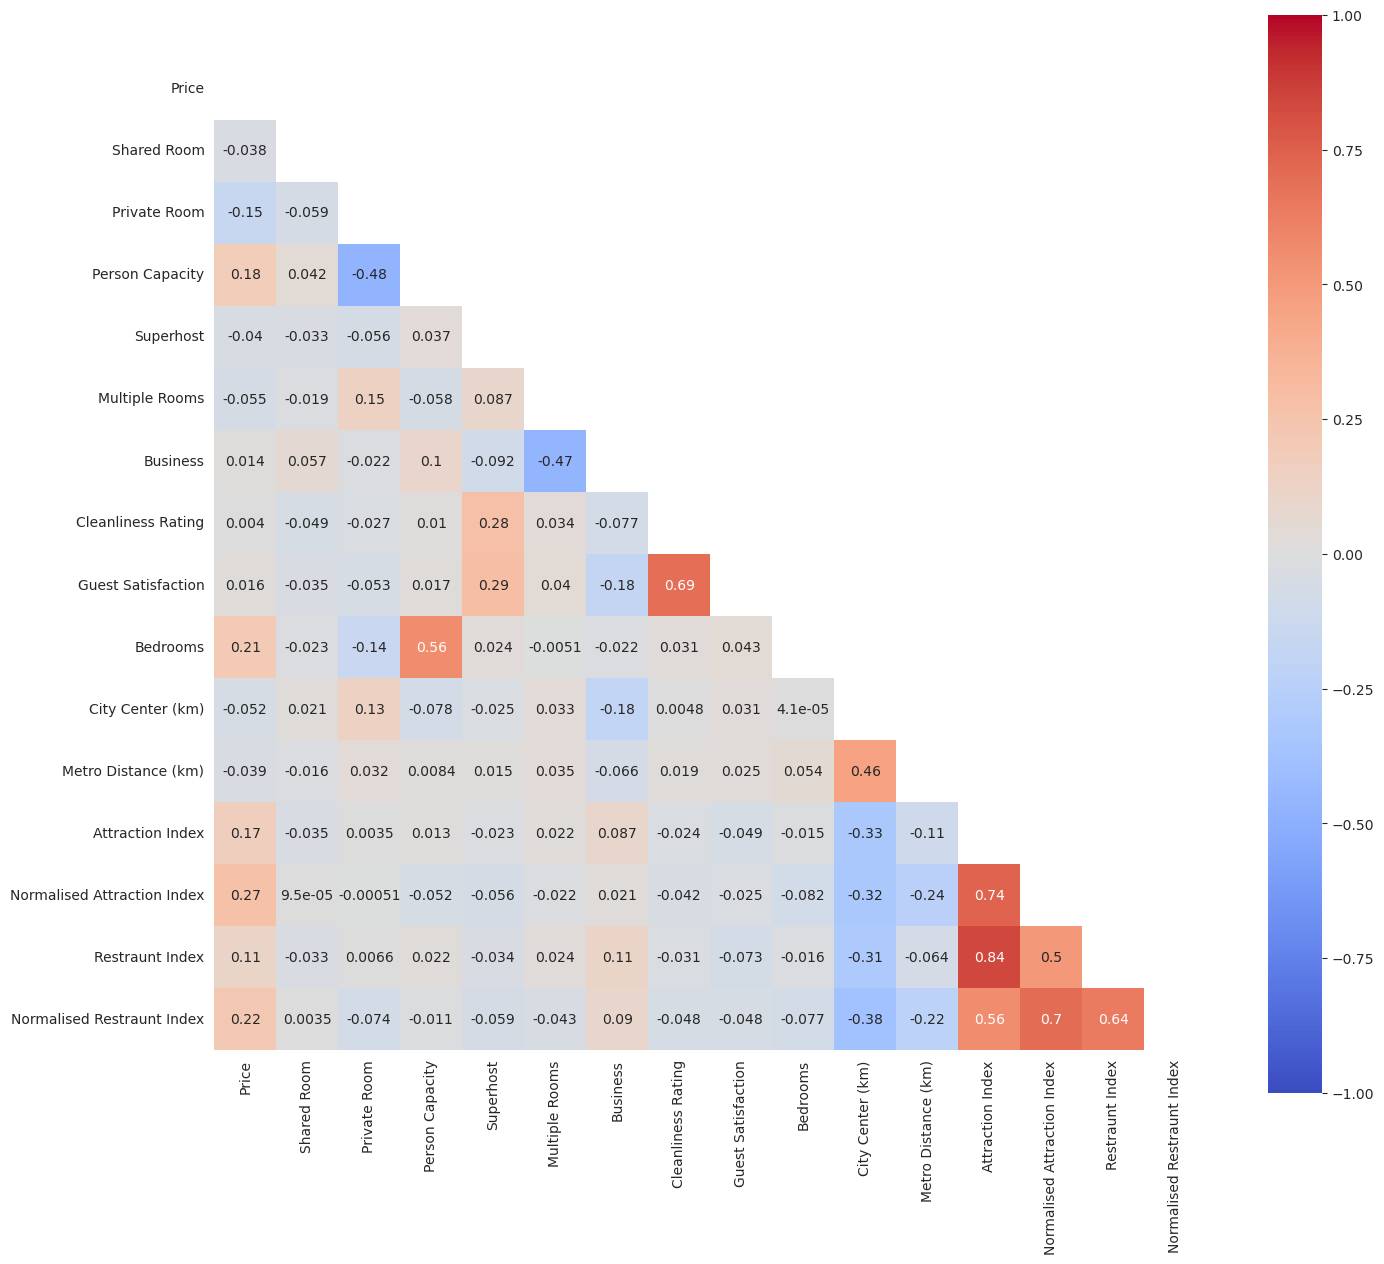

In [7]:
corr = airbnb.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [8]:
#Droping columns presenting multicollinearity

def drop_columns(airbnb) :
    airbnb.drop(columns=["Attraction Index","Restraunt Index"], inplace=True)
    return airbnb

In [9]:
 airbnb1=drop_columns(airbnb)

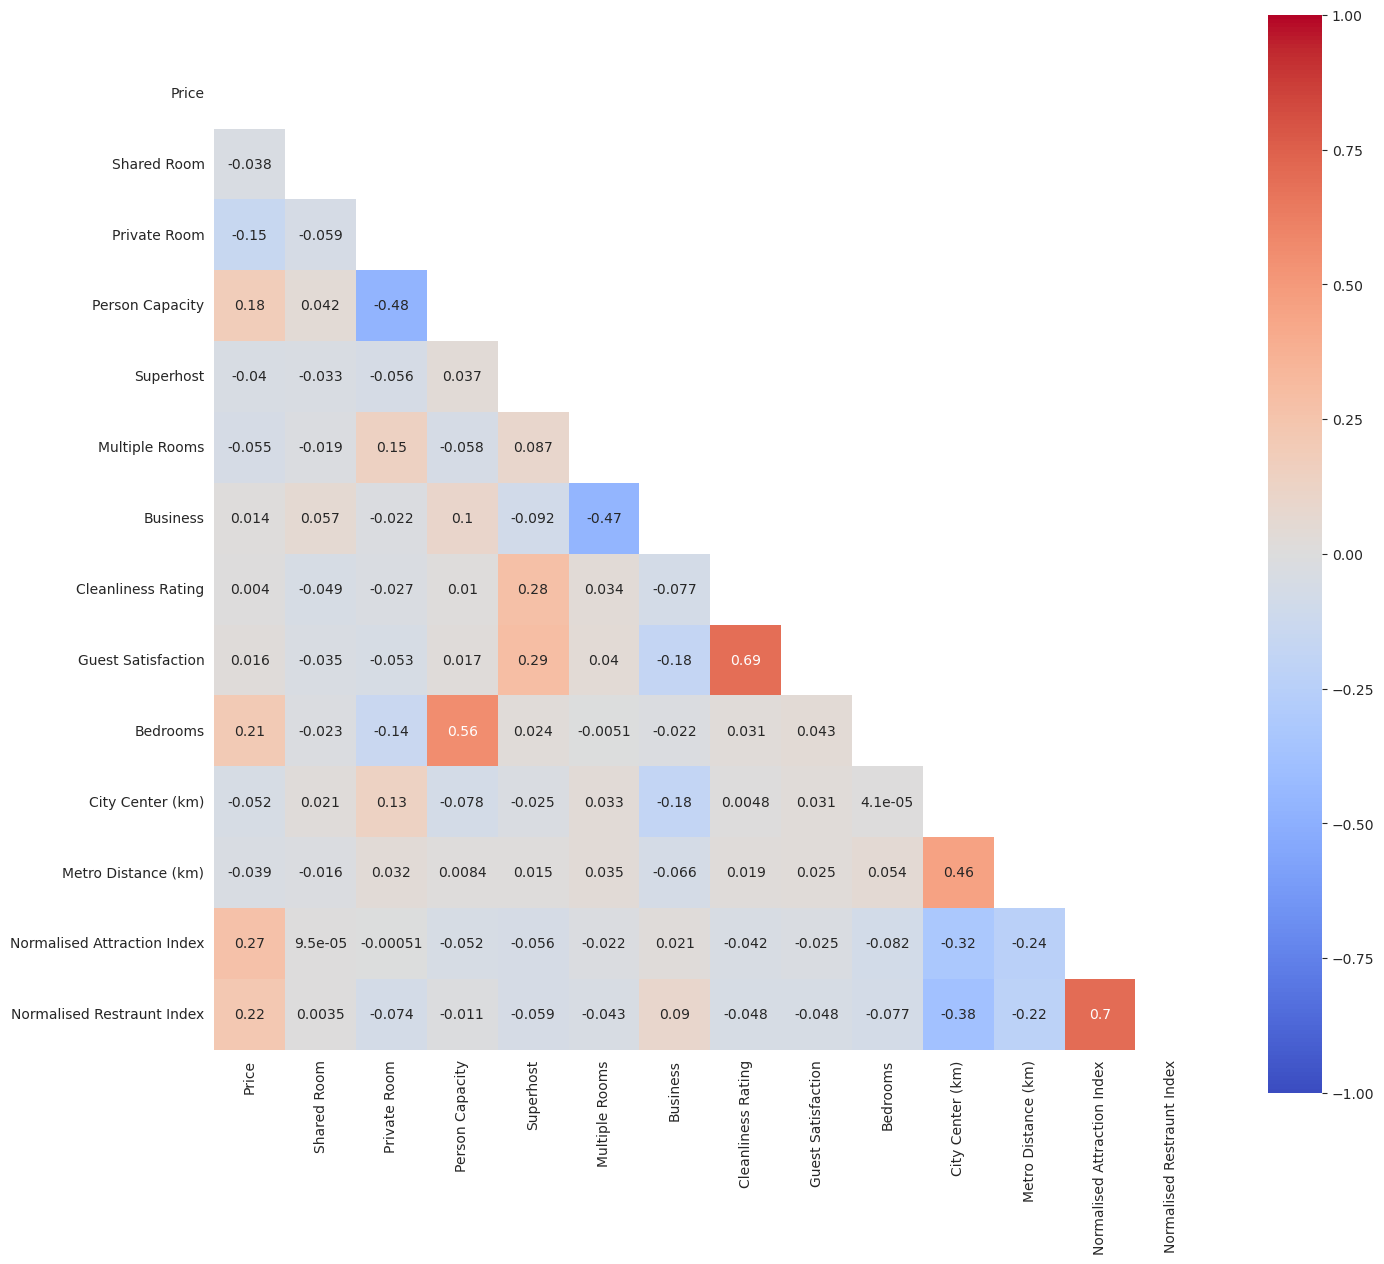

In [10]:
corr = airbnb1.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [15]:
airbnb1.head()

,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Normalised Attraction Index,Normalised Restraunt Index
0,Amsterdam,194.033698,Weekday,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,4.166708,6.846473
1,Amsterdam,344.245776,Weekday,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,33.421209,58.342928
2,Amsterdam,264.101422,Weekday,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,3.985908,6.646700
3,Amsterdam,433.529398,Weekday,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,26.119108,60.973565
4,Amsterdam,485.552926,Weekday,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,29.272733,56.811677


In [16]:
airbnb1['Multiple Rooms'].unique()

array([1, 0], dtype=int64)

In [11]:
# function to change bool into float
def boolstr_to_floatstr(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v

In [12]:
hk_df1['Shared Room'] = np.vectorize(boolstr_to_floatstr)(hk_df1['Shared Room']).astype(float)
hk_df1['Private Room'] = np.vectorize(boolstr_to_floatstr)(hk_df1['Private Room']).astype(float)
hk_df1['Multiple Rooms'] = np.vectorize(boolstr_to_floatstr)(hk_df1['Multiple Rooms']).astype(float)
hk_df1['Superhost'] = np.vectorize(boolstr_to_floatstr)(hk_df1['Superhost']).astype(float)
hk_df1['Bedrooms'] = np.vectorize(boolstr_to_floatstr)(hk_df1['Bedrooms']).astype(float)
hk_df1['Business'] = np.vectorize(boolstr_to_floatstr)(hk_df1['Business']).astype(float)

In [13]:
numericalX = hk_df1.select_dtypes(np.number)
categoricalX = hk_df1.select_dtypes(object)

In [14]:
numericalX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41714 entries, 0 to 41713
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Price                       41714 non-null  float64
 1   Shared Room                 41714 non-null  float64
 2   Private Room                41714 non-null  float64
 3   Person Capacity             41714 non-null  float64
 4   Superhost                   41714 non-null  float64
 5   Multiple Rooms              41714 non-null  float64
 6   Business                    41714 non-null  float64
 7   Cleanliness Rating          41714 non-null  float64
 8   Guest Satisfaction          41714 non-null  float64
 9   Bedrooms                    41714 non-null  float64
 10  City Center (km)            41714 non-null  float64
 11  Metro Distance (km)         41714 non-null  float64
 12  Normalised Restraunt Index  41714 non-null  float64
dtypes: float64(13)
memory usage: 4.

In [15]:
categoricalX['Bedrooms'] = numericalX['Bedrooms']
numericalX = numericalX.drop(columns=['Bedrooms'])

In [16]:
categoricalX['Shared Room'] = numericalX['Shared Room']
numericalX = numericalX.drop(columns=['Shared Room'])

In [17]:
categoricalX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41714 entries, 0 to 41713
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         41714 non-null  object 
 1   Day          41714 non-null  object 
 2   Room Type    41714 non-null  object 
 3   Bedrooms     41714 non-null  float64
 4   Shared Room  41714 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.6+ MB


In [18]:
numericalX=remove_outliers(numericalX)

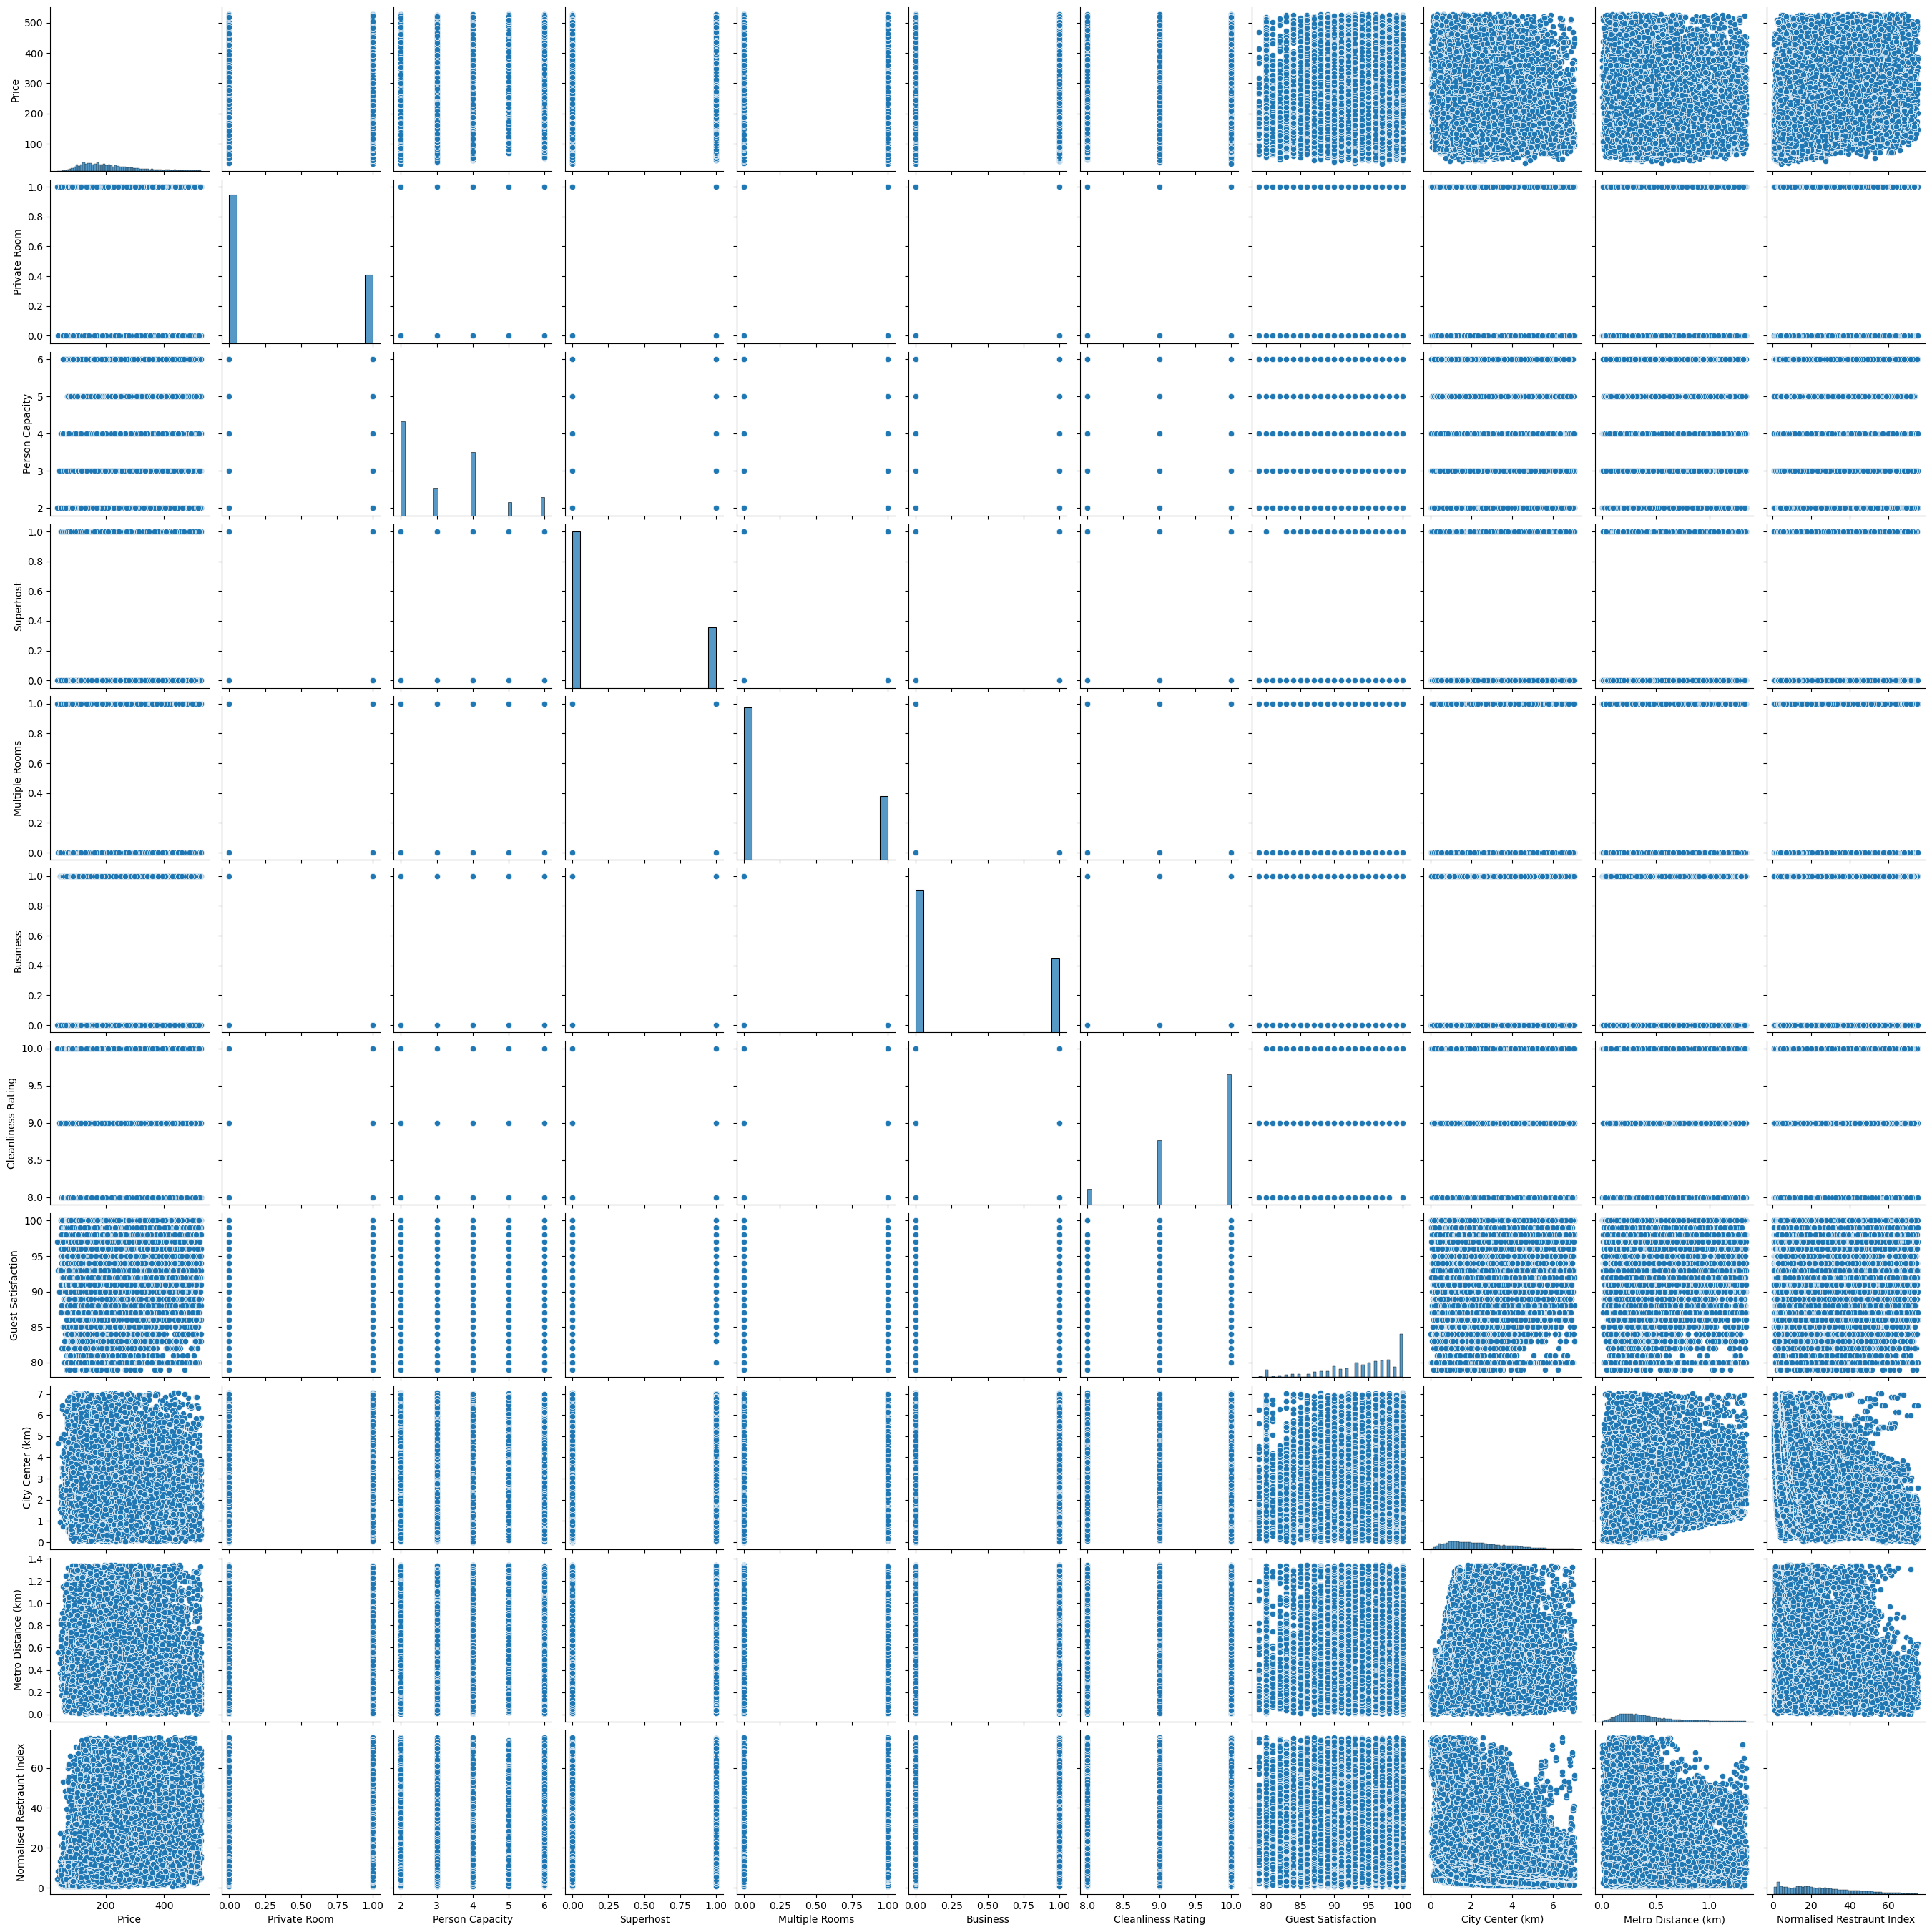

In [19]:
sns.pairplot(numericalX.select_dtypes(np.number))

In [20]:

def replacer(col_name,old_vals,new_vals):
    for i in range(len(old_vals)):
        categoricalX.loc[categoricalX[col_name] == old_vals[i], col_name] = new_vals[i]
    
    return categoricalX[col_name]

In [21]:
# 6 creating a data frame to save the new values of the function 
ordinalsX = pd.DataFrame()

In [22]:
categoricalX['Room Type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [23]:
ordinalsX['Room Type'] = replacer('Room Type', list(categoricalX['Room Type'].unique()), [1,2,0])

In [24]:
hk_df['Bedrooms'].unique()

array([ 1.,  2.,  3.,  0.,  5.,  4.,  6.,  9., 10.])

In [25]:
hk_df.drop(hk_df[hk_df['Bedrooms'] == 0].index, inplace = True)

In [26]:
hk_df.drop(hk_df[hk_df['Bedrooms'] > 6].index, inplace = True)

In [27]:
categoricalX

,City,Day,Room Type,Bedrooms,Shared Room
0,Amsterdam,Weekday,1,1.0,0.0
1,Amsterdam,Weekday,1,1.0,0.0
2,Amsterdam,Weekday,1,1.0,0.0
3,Amsterdam,Weekday,1,2.0,0.0
4,Amsterdam,Weekday,1,1.0,0.0
...,...,...,...,...,...
41709,Vienna,Weekend,2,3.0,0.0
41710,Vienna,Weekend,2,1.0,0.0
41711,Vienna,Weekend,2,1.0,0.0
41712,Vienna,Weekend,1,1.0,0.0


In [28]:
import pandas as pd
categoricalX = pd.get_dummies(categoricalX, columns=['City', 'Day'], drop_first = True)

In [29]:
categoricalX['Shared Room'].unique()

array([0., 1.])

In [30]:
categoricalX = categoricalX.drop('Shared Room', axis=1)

In [31]:
categoricalX

,Room Type,Bedrooms,City_Athens,City_Barcelona,City_Berlin,City_Budapest,City_Lisbon,City_Paris,City_Rome,City_Vienna,Day_Weekend
0,1,1.0,0,0,0,0,0,0,0,0,0
1,1,1.0,0,0,0,0,0,0,0,0,0
2,1,1.0,0,0,0,0,0,0,0,0,0
3,1,2.0,0,0,0,0,0,0,0,0,0
4,1,1.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41709,2,3.0,0,0,0,0,0,0,0,1,1
41710,2,1.0,0,0,0,0,0,0,0,1,1
41711,2,1.0,0,0,0,0,0,0,0,1,1
41712,1,1.0,0,0,0,0,0,0,0,1,1


In [32]:
hk_df['Bedrooms'].unique()

array([1., 2., 3., 5., 4., 6.])

In [33]:
numericalX

,Price,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,City Center (km),Metro Distance (km),Normalised Restraunt Index
0,194.033698,1.0,2.0,0.0,1.0,0.0,10.0,93.0,5.022964,NaN,6.846473
1,344.245776,1.0,4.0,0.0,0.0,0.0,8.0,85.0,0.488389,0.239404,58.342928
2,264.101422,1.0,2.0,0.0,0.0,1.0,9.0,87.0,5.748312,NaN,6.646700
3,433.529398,1.0,4.0,0.0,0.0,1.0,9.0,90.0,0.384862,0.439876,60.973565
4,485.552926,1.0,2.0,1.0,0.0,0.0,10.0,98.0,0.544738,0.318693,56.811677
...,...,...,...,...,...,...,...,...,...,...,...
41709,NaN,0.0,6.0,0.0,0.0,1.0,10.0,100.0,0.530181,0.135447,10.604584
41710,304.793960,0.0,2.0,0.0,0.0,0.0,8.0,86.0,0.810205,0.100839,8.270427
41711,NaN,0.0,2.0,0.0,0.0,0.0,10.0,93.0,0.994051,0.202539,6.822996
41712,301.054157,1.0,2.0,0.0,0.0,0.0,10.0,87.0,3.044100,0.287435,3.832416


In [34]:
df = pd.concat([numericalX, categoricalX], axis=1)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41714 entries, 0 to 41713
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Price                       38823 non-null  float64
 1   Private Room                41714 non-null  float64
 2   Person Capacity             41714 non-null  float64
 3   Superhost                   41714 non-null  float64
 4   Multiple Rooms              41714 non-null  float64
 5   Business                    41714 non-null  float64
 6   Cleanliness Rating          40517 non-null  float64
 7   Guest Satisfaction          40177 non-null  float64
 8   City Center (km)            40302 non-null  float64
 9   Metro Distance (km)         37833 non-null  float64
 10  Normalised Restraunt Index  41178 non-null  float64
 11  Room Type                   41714 non-null  object 
 12  Bedrooms                    41714 non-null  float64
 13  City_Athens                 417

In [36]:
df['Room Type'].unique()

array([1, 2, 0], dtype=object)

In [37]:
df['Room Type'] = np.vectorize(boolstr_to_floatstr)(df['Room Type']).astype(float)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41714 entries, 0 to 41713
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Price                       38823 non-null  float64
 1   Private Room                41714 non-null  float64
 2   Person Capacity             41714 non-null  float64
 3   Superhost                   41714 non-null  float64
 4   Multiple Rooms              41714 non-null  float64
 5   Business                    41714 non-null  float64
 6   Cleanliness Rating          40517 non-null  float64
 7   Guest Satisfaction          40177 non-null  float64
 8   City Center (km)            40302 non-null  float64
 9   Metro Distance (km)         37833 non-null  float64
 10  Normalised Restraunt Index  41178 non-null  float64
 11  Room Type                   41714 non-null  float64
 12  Bedrooms                    41714 non-null  float64
 13  City_Athens                 417

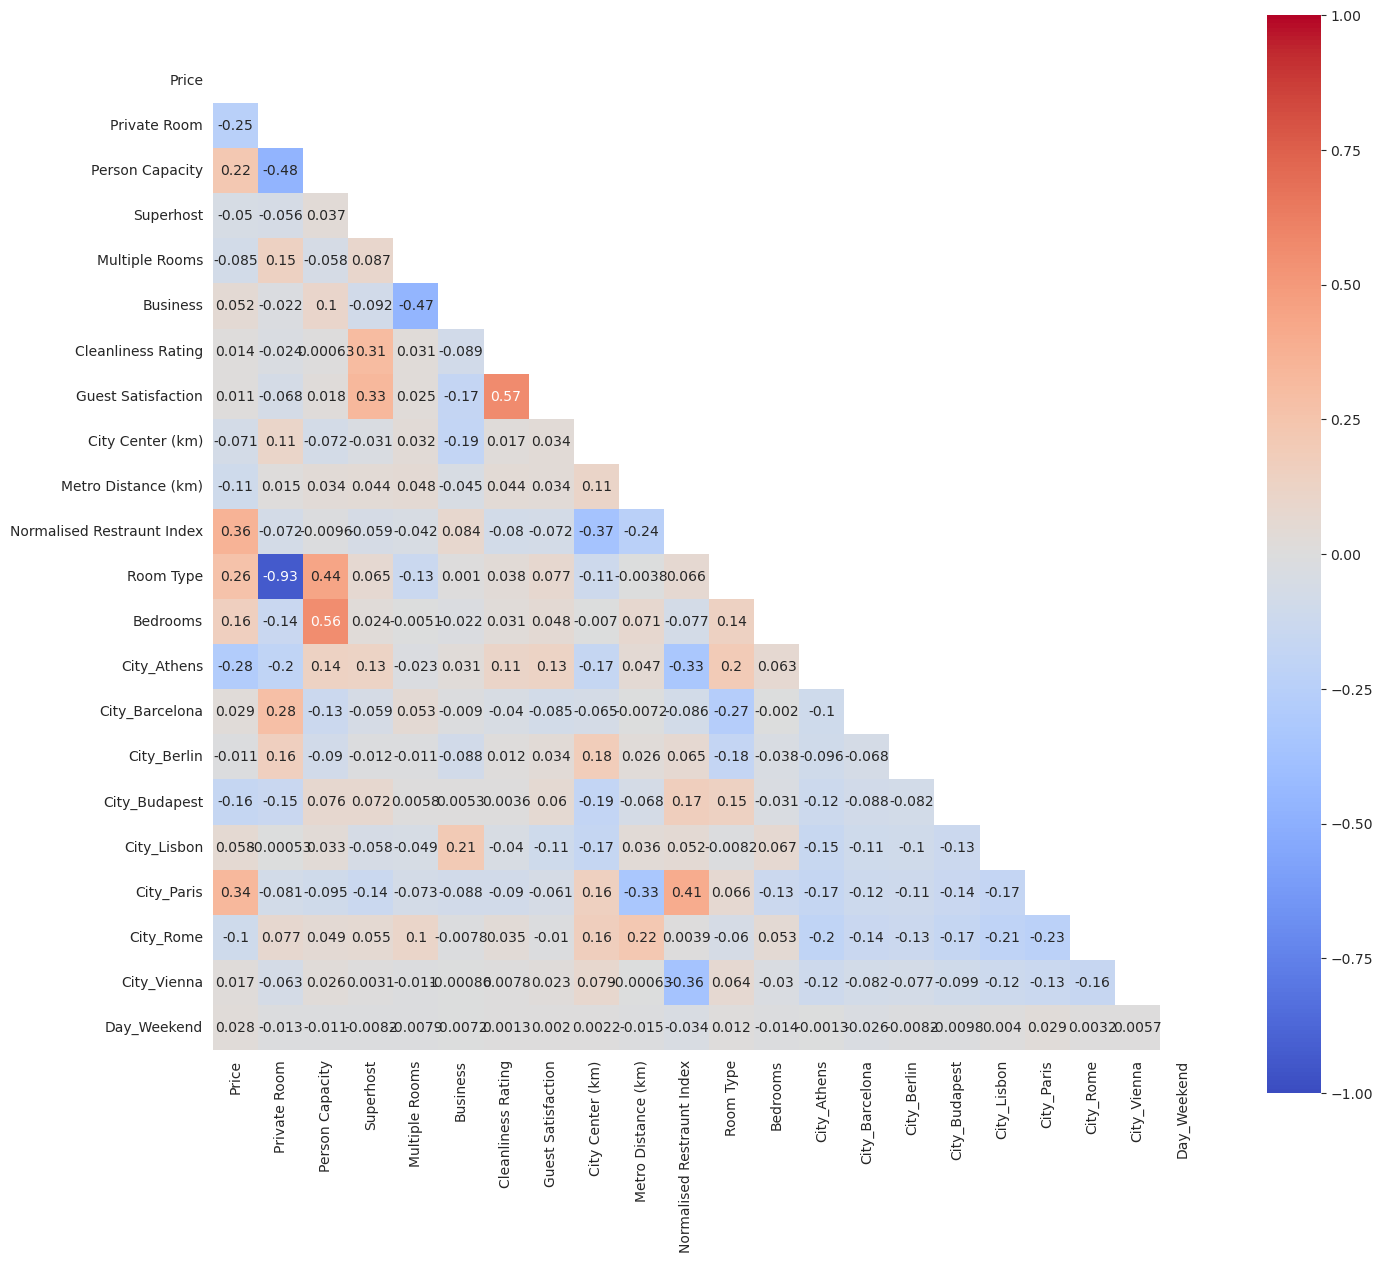

In [39]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [40]:
df.isna().any()

Price                          True
Private Room                  False
Person Capacity               False
Superhost                     False
Multiple Rooms                False
Business                      False
Cleanliness Rating             True
Guest Satisfaction             True
City Center (km)               True
Metro Distance (km)            True
Normalised Restraunt Index     True
Room Type                     False
Bedrooms                      False
City_Athens                   False
City_Barcelona                False
City_Berlin                   False
City_Budapest                 False
City_Lisbon                   False
City_Paris                    False
City_Rome                     False
City_Vienna                   False
Day_Weekend                   False
dtype: bool

In [41]:
na_idcs = df[df.isna().any(axis=1)].index
df = pd.DataFrame(df).drop(na_idcs)
df

,Price,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,City Center (km),Metro Distance (km),...,Bedrooms,City_Athens,City_Barcelona,City_Berlin,City_Budapest,City_Lisbon,City_Paris,City_Rome,City_Vienna,Day_Weekend
1,344.245776,1.0,4.0,0.0,0.0,0.0,8.0,85.0,0.488389,0.239404,...,1.0,0,0,0,0,0,0,0,0,0
3,433.529398,1.0,4.0,0.0,0.0,1.0,9.0,90.0,0.384862,0.439876,...,2.0,0,0,0,0,0,0,0,0,0
4,485.552926,1.0,2.0,1.0,0.0,0.0,10.0,98.0,0.544738,0.318693,...,1.0,0,0,0,0,0,0,0,0,0
6,215.124317,1.0,2.0,0.0,0.0,0.0,10.0,94.0,1.881092,0.729747,...,1.0,0,0,0,0,0,0,0,0,0
9,276.521454,1.0,2.0,0.0,1.0,0.0,10.0,88.0,3.142361,0.924404,...,1.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41704,463.501858,0.0,5.0,0.0,1.0,0.0,10.0,90.0,1.021878,0.285141,...,2.0,0,0,0,0,0,0,0,1,1
41707,115.933899,1.0,4.0,0.0,1.0,0.0,9.0,94.0,3.041932,0.308192,...,1.0,0,0,0,0,0,0,0,1,1
41710,304.793960,0.0,2.0,0.0,0.0,0.0,8.0,86.0,0.810205,0.100839,...,1.0,0,0,0,0,0,0,0,1,1
41712,301.054157,1.0,2.0,0.0,0.0,0.0,10.0,87.0,3.044100,0.287435,...,1.0,0,0,0,0,0,0,0,1,1


In [42]:
X = df.drop('Price', axis=1)
y = df.Price

In [43]:
# test-train split
#tt_ratio id defined above 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.head(3)

,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,City Center (km),Metro Distance (km),Normalised Restraunt Index,...,Bedrooms,City_Athens,City_Barcelona,City_Berlin,City_Budapest,City_Lisbon,City_Paris,City_Rome,City_Vienna,Day_Weekend
15776,0.0,4.0,0.0,1.0,0.0,10.0,100.0,1.215349,0.318456,37.627309,...,0.0,0,0,0,1,0,0,0,0,1
25315,0.0,2.0,0.0,0.0,0.0,10.0,100.0,6.855428,1.154777,22.405221,...,1.0,0,0,0,0,0,1,0,0,0
8426,1.0,2.0,0.0,0.0,0.0,10.0,97.0,3.563029,0.192331,9.296461,...,1.0,0,1,0,0,0,0,0,0,0


In [45]:
#for stats models we have add a cosntant
X_train_const = sm.add_constant(X_train.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const).fit()
predictions_train = model.predict(X_train_const)

X_test_const = sm.add_constant(X_test) # adding a constant
predictions_test = model.predict(X_test_const)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     1390.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:46:05   Log-Likelihood:            -1.2647e+05
No. Observations:               22594   AIC:                         2.530e+05
Df Residuals:                   22572   BIC:                         2.532e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -40.8329     11.081     -3.685      0.0

In [53]:
df2 = df.drop('Multiple Rooms', axis=1)

In [55]:
A = df2.drop('Price', axis=1)
b = df2.Price
df2

,Price,Private Room,Person Capacity,Superhost,Business,Cleanliness Rating,Guest Satisfaction,City Center (km),Metro Distance (km),Normalised Restraunt Index,...,Bedrooms,City_Athens,City_Barcelona,City_Berlin,City_Budapest,City_Lisbon,City_Paris,City_Rome,City_Vienna,Day_Weekend
1,344.245776,1.0,4.0,0.0,0.0,8.0,85.0,0.488389,0.239404,58.342928,...,1.0,0,0,0,0,0,0,0,0,0
3,433.529398,1.0,4.0,0.0,1.0,9.0,90.0,0.384862,0.439876,60.973565,...,2.0,0,0,0,0,0,0,0,0,0
4,485.552926,1.0,2.0,1.0,0.0,10.0,98.0,0.544738,0.318693,56.811677,...,1.0,0,0,0,0,0,0,0,0,0
6,215.124317,1.0,2.0,0.0,0.0,10.0,94.0,1.881092,0.729747,16.916251,...,1.0,0,0,0,0,0,0,0,0,0
9,276.521454,1.0,2.0,0.0,0.0,10.0,88.0,3.142361,0.924404,16.604478,...,1.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41704,463.501858,0.0,5.0,0.0,0.0,10.0,90.0,1.021878,0.285141,6.850308,...,2.0,0,0,0,0,0,0,0,1,1
41707,115.933899,1.0,4.0,0.0,0.0,9.0,94.0,3.041932,0.308192,5.039797,...,1.0,0,0,0,0,0,0,0,1,1
41710,304.793960,0.0,2.0,0.0,0.0,8.0,86.0,0.810205,0.100839,8.270427,...,1.0,0,0,0,0,0,0,0,1,1
41712,301.054157,1.0,2.0,0.0,0.0,10.0,87.0,3.044100,0.287435,3.832416,...,1.0,0,0,0,0,0,0,0,1,1


In [56]:
# test-train split
#tt_ratio id defined above 
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=TT_RATIO, random_state=RAND_STATE)
A_train = pd.DataFrame(A_train)
A_test = pd.DataFrame(A_test)
A_train.head(3)

,Private Room,Person Capacity,Superhost,Business,Cleanliness Rating,Guest Satisfaction,City Center (km),Metro Distance (km),Normalised Restraunt Index,Room Type,Bedrooms,City_Athens,City_Barcelona,City_Berlin,City_Budapest,City_Lisbon,City_Paris,City_Rome,City_Vienna,Day_Weekend
15776,0.0,4.0,0.0,0.0,10.0,100.0,1.215349,0.318456,37.627309,2.0,0.0,0,0,0,1,0,0,0,0,1
25315,0.0,2.0,0.0,0.0,10.0,100.0,6.855428,1.154777,22.405221,2.0,1.0,0,0,0,0,0,1,0,0,0
8426,1.0,2.0,0.0,0.0,10.0,97.0,3.563029,0.192331,9.296461,1.0,1.0,0,1,0,0,0,0,0,0,0


In [57]:
A_train_const = sm.add_constant(A_train.to_numpy()) # adding a constant

model = sm.OLS(y_train, A_train_const).fit()
predictions_train = model.predict(A_train_const)

A_test_const = sm.add_constant(A_test) # adding a constant
predictions_test = model.predict(A_test_const)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     1453.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:57:18   Log-Likelihood:            -1.2650e+05
No. Observations:               22594   AIC:                         2.530e+05
Df Residuals:                   22573   BIC:                         2.532e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.9660     11.046     -2.984      0.0